In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

from skimage.morphology import closing, square
from tools import *
from plot import *

In [2]:
indiana_img = np.load('../data/indianapines.npy')
indiana_labels = np.load('../data/indianapines_gt.npy')
salinas_img = np.load('../data/salinas.npy')
salinas_labels = np.load('../data/salinas_gt.npy')

In [3]:
# normalize radiance values to get reflectance values
indiana_img = indiana_img / indiana_img.max()
salinas_img = salinas_img / salinas_img.max()

In [4]:
print("Indiana shape: {}".format(indiana_img.shape))
print("Salinas shape: {}".format(salinas_img.shape))

Indiana shape: (145, 145, 200)
Salinas shape: (512, 217, 204)


In [5]:
X_indiana = indiana_img.reshape((-1, indiana_img.shape[-1])) # reshaping the HSI as a 2D matrix
print("Indiana shape: {}".format(X_indiana.shape))

X_salinas = salinas_img.reshape((-1, salinas_img.shape[-1])) # reshaping the HSI as a 2D matrix
print("Salinas shape: {}".format(X_salinas.shape))

Indiana shape: (21025, 200)
Salinas shape: (111104, 204)


In [6]:
n_cluster_indiana = len(np.unique(indiana_labels)) - 1
n_cluster_salinas = len(np.unique(salinas_labels)) - 1

## Remove unclassified data

In [7]:
X_indiana, X_indiana_idx = remove_unclassified_input(X_indiana, indiana_labels)
X_salinas, X_salinas_idx = remove_unclassified_input(X_salinas, salinas_labels)

In [8]:
print(X_indiana.shape)
print(X_salinas.shape)

(10249, 200)
(54129, 204)


In [9]:
print(X_indiana_idx)
print(X_salinas_idx)

[    0     1     2 ... 20765 20766 20767]
[   305    306    307 ... 110691 110692 110693]


In [10]:
indiana_labels, _ = remove_unclassified_input(indiana_labels.flatten(), indiana_labels)
salinas_labels, _ = remove_unclassified_input(salinas_labels.flatten(), salinas_labels)

In [11]:
print(indiana_labels.shape)
print(salinas_labels.shape)

(10249,)
(54129,)


## PCA

In [12]:
n_components_indiana = get_number_components(X_indiana)
n_components_salinas = get_number_components(X_salinas)

Fitting the PCA
Fitting the PCA


In [13]:
print("Number of components Indiana: {}".format(n_components_indiana))
print("Number of components Salinas: {}".format(n_components_salinas))

Number of components Indiana: 68
Number of components Salinas: 5


In [14]:
X_indiana_reduced = extract_features(X_indiana, n_components_indiana)
X_salinas_reduced = extract_features(X_salinas, n_components_salinas)

In [15]:
print("Indiana reduced data shape: {}".format(X_indiana_reduced.shape))
print("Salinas reduced data shape: {}".format(X_salinas_reduced.shape))

Indiana reduced data shape: (10249, 68)
Salinas reduced data shape: (54129, 5)


## Split train / test

In [16]:
# shuffle manually
X_indiana_shuffle, indiana_labels_shuffle, shuffle_arr = shuffle(X_indiana_reduced, indiana_labels)

# shuffle index
X_indiana_idx[np.arange(indiana_labels_shuffle.size)] = X_indiana_idx[shuffle_arr]

In [17]:
nb_test = int(X_indiana_shuffle.shape[0] * 0.25)
X_train_indiana = X_indiana_shuffle[nb_test:]
y_train_indiana = indiana_labels_shuffle[nb_test:]
X_test_indiana = X_indiana_shuffle[:nb_test]
y_test_indiana = indiana_labels_shuffle[:nb_test]

In [24]:
y_indiana_labels_argsort = np.argsort(indiana_labels_shuffle)

In [26]:
print(y_indiana_labels_argsort[:10])

[5742  389 6423 9022 4197 3971 5443 5700 8479 4077]


In [31]:
indiana_labels_shuffle[5742]


for i in range(1, n_cluster_indiana + 1):
    print(indiana_labels_shuffle[indiana_labels_shuffle == i].size)
    

46
1428
830
237
483
730
28
478
20
972
2455
593
205
1265
386
93


In [48]:
labels, count = np.unique(indiana_labels_shuffle-1, return_counts=True)

In [100]:
a = np.array([12,3])
b = np.array([1,2])
np.hstack((a,b))

array([12,  3,  1,  2])

In [103]:
sum_ = 0
x_train_indiana = np.empty((0, 68))
x_test_indiana = np.empty((0, 68))

train_indiana_argsort = np.array([])
test_indiana_argsort = np.array([])

y_train_indiana_labels = np.array([])
y_test_indiana_labels = np.array([])

for cluster in labels:
    idx = int(count[cluster] * 0.75)

    train_indiana_argsort = np.hstack((train_indiana_argsort, y_indiana_labels_argsort[sum_:sum_+idx]))
    print(X_indiana_shuffle[y_indiana_labels_argsort[sum_:sum_+idx]].shape)
    print(x_train_indiana.shape)
    x_train_indiana = np.vstack((x_train_indiana, X_indiana_shuffle[y_indiana_labels_argsort[sum_:sum_+idx]]))
    y_train_indiana_labels = np.hstack((y_train_indiana_labels, np.full((idx), cluster)))

    test_indiana_argsort = np.hstack((test_indiana_argsort, y_indiana_labels_argsort[sum_+idx: sum_ + count[cluster]]))   
    x_test_indiana = np.vstack((x_test_indiana, X_indiana_shuffle[y_indiana_labels_argsort[sum_+idx: sum_ + count[cluster]]]))    
    y_test_indiana_labels = np.hstack((y_test_indiana_labels, np.full((count[cluster] - idx), cluster)))
    
    sum_ += count[cluster]

(34, 68)
(0, 68)
(1071, 68)
(34, 68)
(622, 68)
(1105, 68)
(177, 68)
(1727, 68)
(362, 68)
(1904, 68)
(547, 68)
(2266, 68)
(21, 68)
(2813, 68)
(358, 68)
(2834, 68)
(15, 68)
(3192, 68)
(729, 68)
(3207, 68)
(1841, 68)
(3936, 68)
(444, 68)
(5777, 68)
(153, 68)
(6221, 68)
(948, 68)
(6374, 68)
(289, 68)
(7322, 68)
(69, 68)
(7611, 68)


In [104]:
x_train_indiana = np.array(x_train_indiana)
x_test_indiana = np.array(x_test_indiana)

y_train_indiana_labels = np.array(y_train_indiana_labels)
y_test_indiana_labels = np.array(y_test_indiana_labels)

In [105]:
x_train_indiana[1].shape

(68,)

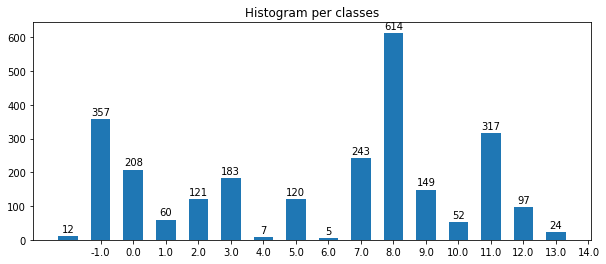

In [109]:
fig, axs = plt.subplots(figsize=(10, 4))
bar_x, bar_count = np.unique(y_test_indiana_labels-1, return_counts=True)

bar = axs.bar(bar_x, bar_count, 0.6)
axs.bar_label(bar, padding=2)

axs.set_xticks(np.arange(len(bar_x)))
axs.set_xticklabels(bar_x)

axs.set_title('Histogram per classes')
plt.show()

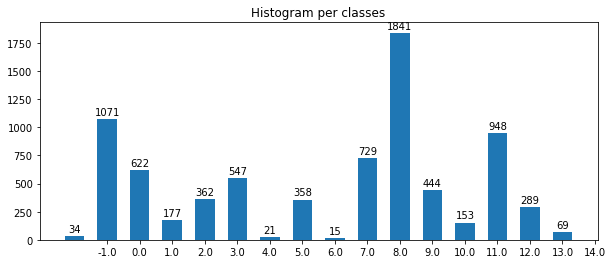

In [110]:
fig, axs = plt.subplots(figsize=(10, 4))
bar_x, bar_count = np.unique(y_train_indiana_labels-1, return_counts=True)

bar = axs.bar(bar_x, bar_count, 0.6)
axs.bar_label(bar, padding=2)

axs.set_xticks(np.arange(len(bar_x)))
axs.set_xticklabels(bar_x)

axs.set_title('Histogram per classes')
plt.show()

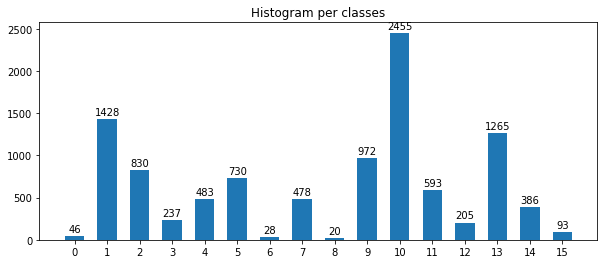

In [111]:
fig, axs = plt.subplots(figsize=(10, 4))
bar_x, bar_count = np.unique(indiana_labels_shuffle-1, return_counts=True)

bar = axs.bar(bar_x, bar_count, 0.6)
axs.bar_label(bar, padding=2)

axs.set_xticks(np.arange(len(bar_x)))
axs.set_xticklabels(bar_x)

axs.set_title('Histogram per classes')
plt.show()

In [18]:
print("X_train shape: {}".format(X_train_indiana.shape))
print("X_test shape: {}".format(X_test_indiana.shape))
print("y_train shape: {}".format(y_train_indiana.shape))
print("y_test shape: {}".format(y_test_indiana.shape))

X_train shape: (7687, 68)
X_test shape: (2562, 68)
y_train shape: (7687,)
y_test shape: (2562,)


## Random Forest

In [19]:
modelRF = RandomForestClassifier(n_estimators=100, verbose=1, n_jobs=8)

In [20]:
modelRF.fit(X_train_indiana, y_train_indiana)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    4.7s finished


RandomForestClassifier(n_jobs=8, verbose=1)

In [21]:
# training score
modelRF.score(X_train_indiana, y_train_indiana)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished


1.0

In [23]:
# testing score
modelRF.score(X_test_indiana, y_test_indiana)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


0.8208430913348946

In [24]:
preds_test = modelRF.predict(X_test_indiana)
preds_train = modelRF.predict(X_train_indiana)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished


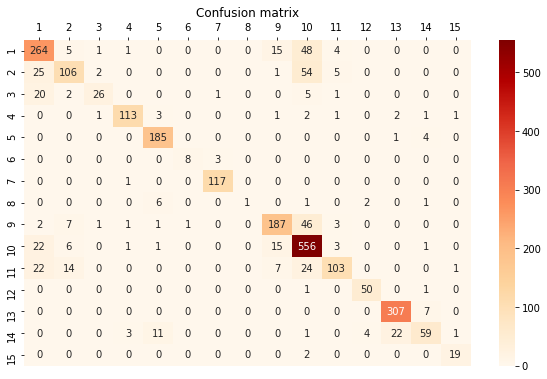

In [25]:
plot_confusion_matrix(y_test_indiana, preds_test, class_names=np.arange(1, 16))

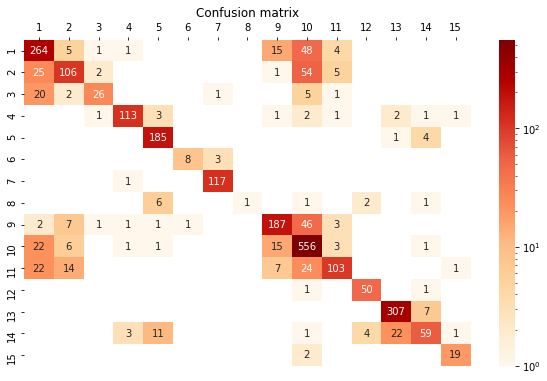

In [26]:
plot_confusion_matrix(y_test_indiana, preds_test, class_names=np.arange(1, 16), log=True)

In [27]:
preds = np.hstack((preds_test, preds_train))

In [28]:
labels = np.hstack((y_test_indiana, y_train_indiana))

In [29]:
pred_img = np.zeros((indiana_img.shape[0] * indiana_img.shape[1]))
pred_img[X_indiana_idx] = preds

In [30]:
labels_img = np.zeros((indiana_img.shape[0] * indiana_img.shape[1]))
labels_img[X_indiana_idx] = labels

In [31]:
pred_img.shape

(21025,)

In [32]:
labels_img.shape

(21025,)

In [33]:
pred_img = pred_img.reshape((indiana_img.shape[0], indiana_img.shape[1]))

In [34]:
labels_img = labels_img.reshape((indiana_img.shape[0], indiana_img.shape[1]))

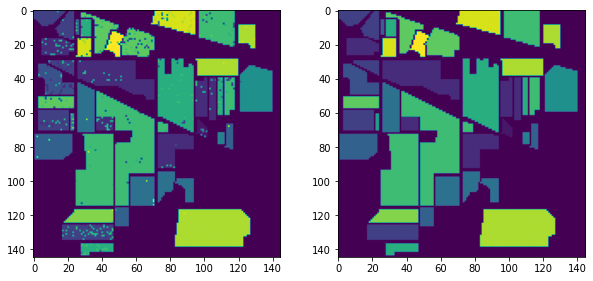

In [35]:
plot_two_figures(pred_img, labels_img)

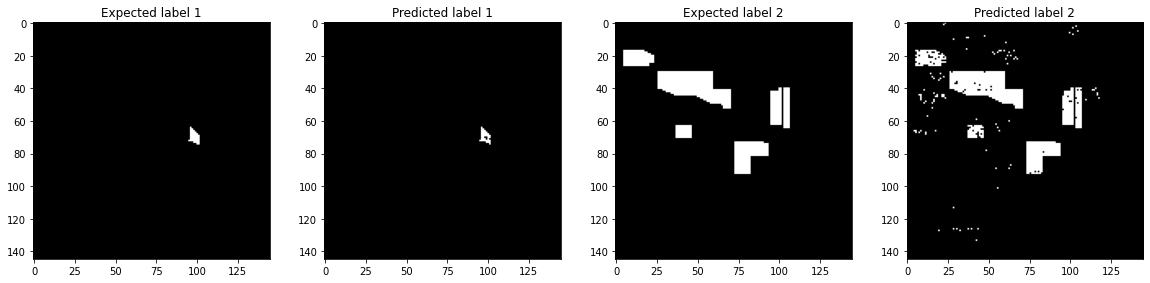

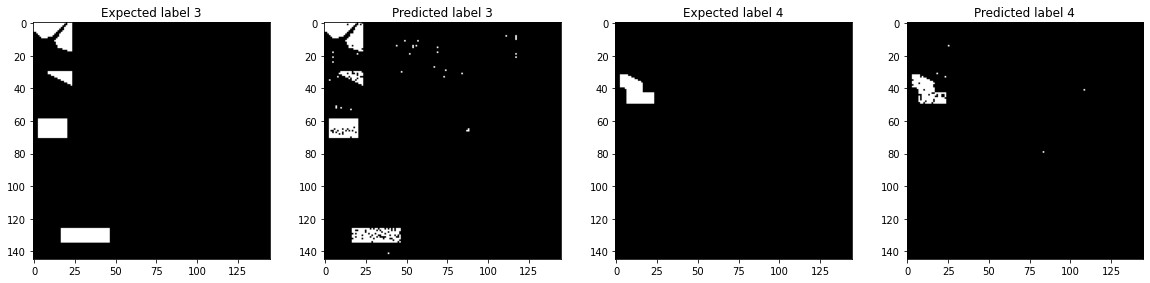

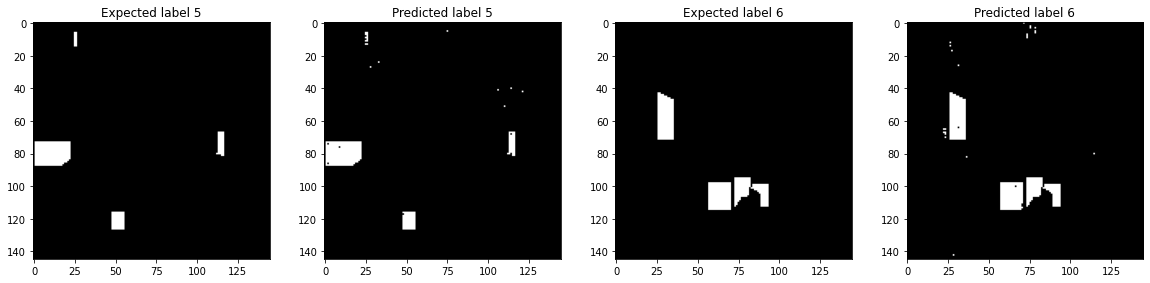

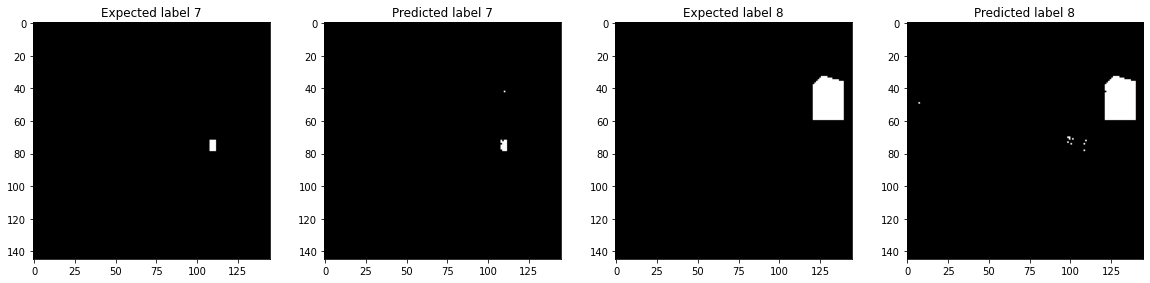

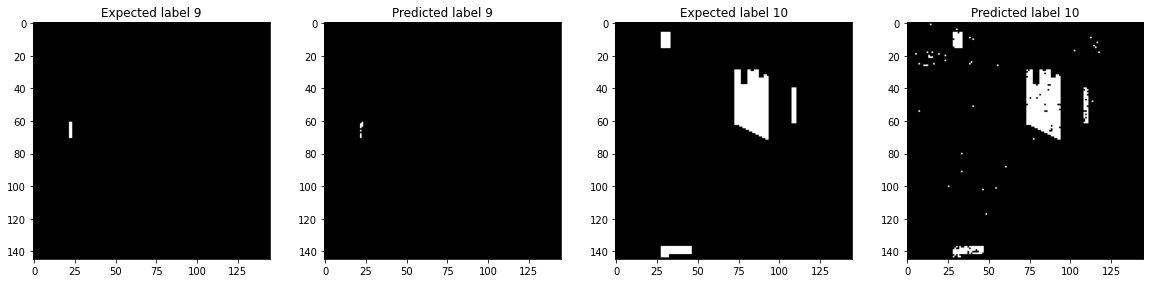

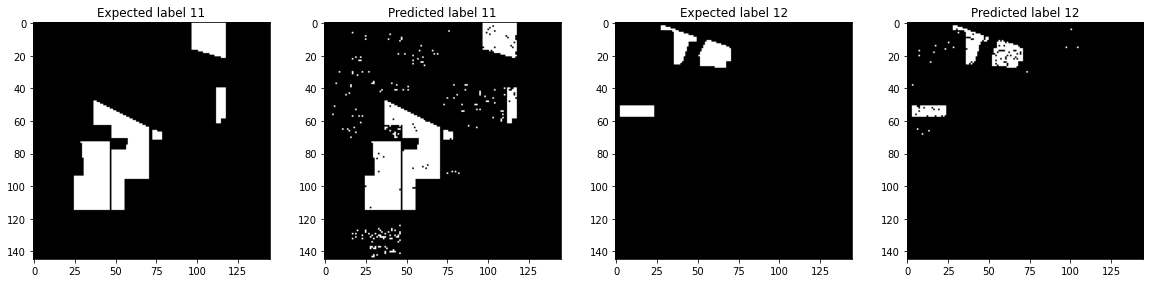

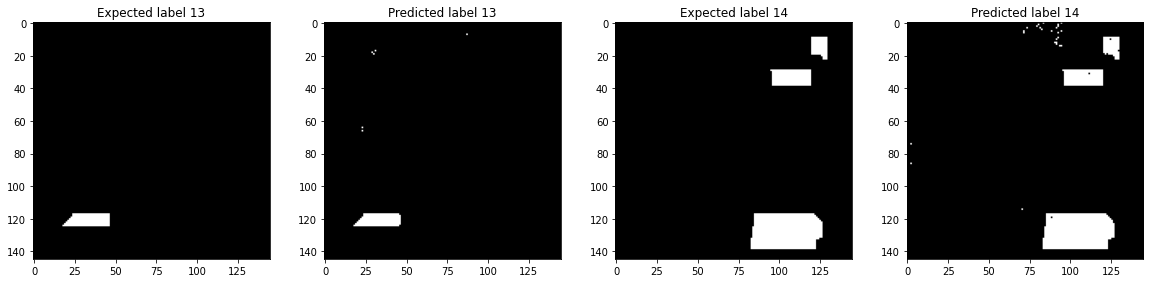

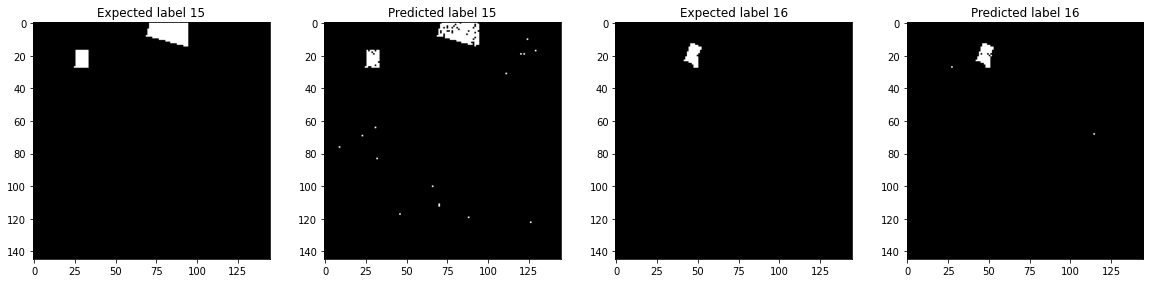

In [36]:
plot_each_labels(labels_img, pred_img, n_cluster_indiana, figsize=(20, 20), cmap='gray')